### Import Libraries

In [1]:
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import imgaug.augmenters as iaa

import sklearn.metrics as metrics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from celluloid import Camera
from IPython.display import HTML

from dataset import LungDataset
from model import UNet

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

### Data Preperation

In [2]:
# Define data augmentations
seq = iaa.Sequential([
    iaa.Affine(scale=(0.85, 1.15),
    rotate=(-45, 45)),
    iaa.ElasticTransformation()
])

In [3]:
# Define paths
train_path = Path('../Preprocessed/train/')
val_path = Path('../Preprocessed/val/')

# Create training dataset
train_dataset = LungDataset(train_path, seq)

# Create val dataset
val_dataset = LungDataset(val_path, None)


#### Oversampling

In [4]:
target_list = []
for _, label in train_dataset:
    # Check if mask contains a tumorous pixel:
    if np.any(label):
        target_list.append(1)
    else:
        target_list.append(0)

unique = np.unique(target_list, return_counts=True)
ratio = unique[1][0] / unique[1][1]
ratio

8.219269102990033

In [5]:
weight_list = []

for target in target_list:
    if target == 0:
        weight_list.append(1)
    else:
        weight_list.append(ratio)

In [6]:
sampler = torch.utils.data.sampler.WeightedRandomSampler(weight_list, len(weight_list))

In [7]:
# Define variables
batch_size = 8
num_workers = 4

# Create data loaders
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    sampler=sampler
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=False
)

### Create Segmentation Model

In [43]:
# Define the TumorSegmentation class as a LightningModule
class TumorSegmentation(pl.LightningModule):
    def __init__(self):
        super().__init__()

        # Create an instance of the UNet model
        self.model = UNet()

        # Define the Adam optimizer for model parameters with a learning rate of 1e-4
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)

        # Define the loss function for binary classification with logits
        self.loss_fn = torch.nn.BCEWithLogitsLoss()

    # Define the forward pass of the model
    def forward(self, data):
        pred = self.model(data)
        return pred

    # Define the training step for the LightningModule
    def training_step(self, batch, batch_idx):
        # Unpack the batch into CT scan images and their corresponding masks
        ct_scan, mask = batch
        mask = mask.float()

        # Perform the forward pass to get the model predictions
        pred = self(ct_scan)

        # Calculate the binary cross-entropy loss between predictions and masks
        loss = self.loss_fn(pred, mask)

        # Log the loss and images periodically during training
        self.log("Train Loss", loss)
        if batch_idx % 50 == 0:
            self.log_images(ct_scan.cpu(), pred.cpu(), mask.cpu(), "Train")

        return loss

    # Define the validation step for the LightningModule
    def validation_step(self, batch, batch_idx):
        # Unpack the batch into CT scan images and their corresponding masks
        ct_scan, mask = batch
        mask = mask.float()

        # Perform the forward pass to get the model predictions
        pred = self(ct_scan)

        # Calculate the binary cross-entropy loss between predictions and masks
        loss = self.loss_fn(pred, mask)

        # Log the loss and images periodically during validation
        self.log("Val Loss", loss)
        if batch_idx % 50 == 0:
            self.log_images(ct_scan.cpu(), pred.cpu(), mask.cpu(), "Val")

        return loss

    # Define a method to log CT scan images, actual masks, and predicted masks
    def log_images(self, ct_scan, pred, mask, name):
        results = []

        # Threshold the predicted masks to obtain binary masks
        pred = pred > 0.5

        # Create a figure with two subplots to display actual and predicted masks
        fig, axis = plt.subplots(1, 2)
        axis[0].imshow(ct_scan[0][0], cmap="bone")
        mask_ = np.ma.masked_where(mask[0][0] == 0, mask[0][0])
        axis[0].imshow(mask_, alpha=0.6)
        axis[0].set_title("Actual")

        axis[1].imshow(ct_scan[0][0], cmap="bone")
        mask_ = np.ma.masked_where(mask[0][0] == 0, mask[0][0])
        axis[1].imshow(mask_, alpha=0.6)
        axis[1].set_title("Predicted")

        # Add the figure to the experiment's logger for visualization
        self.logger.experiment.add_figure(f"{name} Actual vs Prediction", fig, self.global_step)

    # Define a method to configure the optimizer
    def configure_optimizers(self):
        return [self.optimizer]

In [34]:
# Create checkpoint
checkpoint_callback = ModelCheckpoint(
    monitor='Val Loss',
    save_top_k=10,
    mode='min'
)

In [35]:
# Intialize the model
model = TumorSegmentation()

In [36]:
# Create PyTorch Lightning Trainer
trainer = pl.Trainer(
    devices=1,
    accelerator='gpu',
    logger=TensorBoardLogger(save_dir='../logs'),
    log_every_n_steps=1,
    callbacks=checkpoint_callback,
    max_epochs=30
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [37]:
# Train model
trainer.fit(model, train_loader, val_loader)


  | Name    | Type              | Params
----------------------------------------------
0 | model   | UNet              | 7.8 M 
1 | loss_fn | BCEWithLogitsLoss | 0     
----------------------------------------------
7.8 M     Trainable params
0         Non-trainable params
7.8 M     Total params
31.127    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.


### Model Evaluation

In [38]:
# After training the model
model = TumorSegmentation.load_from_checkpoint("../logs/lightning_logs/version_0/checkpoints/epoch=27-step=48580.ckpt")
model.eval()
device = "mps" if torch.backends.mps.is_available() else "cpu"
model.to(device)

TumorSegmentation(
  (model): UNet(
    (layer1): DoubleConvBlock(
      (step): Sequential(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
      )
    )
    (layer2): DoubleConvBlock(
      (step): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
      )
    )
    (layer3): DoubleConvBlock(
      (step): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
      )
    )
    (layer4): DoubleConvBlock(
      (step): Sequential(
        (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): 

In [39]:
# Create class to evaluate dice score
class DiceScore(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, pred, mask):
        pred = torch.flatten(pred)
        mask = torch.flatten(mask)

        intersection = (pred * mask).sum() 
        union = pred.sum() + mask.sum()
        dice = (2.0 * intersection) / union

        return dice

In [40]:
dice_score_calculator = DiceScore()
dice_scores = []

for slice, label in val_dataset:
    slice = torch.tensor(slice).float().to(device).unsqueeze(0)
    with torch.no_grad():
        pred = torch.sigmoid(model(slice))
    dice_score = dice_score_calculator(pred, torch.tensor(label).float().unsqueeze(0).to(device))
    dice_scores.append(dice_score.item())


In [41]:

average_dice_score = sum(dice_scores) / len(dice_scores)
print(f"The Val Dice Score is: {average_dice_score:.4f}")


The Val Dice Score is: 0.0247


### Visualization

In [ ]:
import nibabel as nib
import cv2

In [ ]:
sample_patient = path = Path("./Data/Task06_Lung/imagesTr/lung_006.nii.gz")
ct_scan = nib.load(sample_patient).get_fdata() / 3071
ct_scan = ct_scan[:,:,30:]

segmentation, label, scan = [], [], []

for i in range(ct_scan.shape[-1]):
    slice = ct_scan[:, :, i]
    slice = cv2.resize(slice, (256, 256))
    slice = torch.tensor(slice)
    scan.append(slice)
    slice = slice.unsqueeze(0).unsqueeze(0).float().to(device)

    with torch.no_grad():
        pred = model(slice)[0][0].cpu()
    pred = pred > 0.5
    segmentation.append(pred)
    label.append(segmentation)


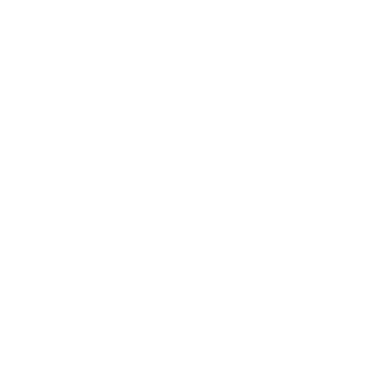

In [ ]:
fig = plt.figure()
camera = Camera(fig)

for i in range(0, len(scan), 2): 
    plt.imshow(scan[i], cmap="bone")
    mask = np.ma.masked_where(segmentation[i]==0, segmentation[i])
    plt.imshow(mask, alpha=0.5, cmap="autumn")
    plt.axis("off")
    camera.snap()

animation = camera.animate()
HTML(animation.to_html5_video())

